## Automatic Differentiation

In [1]:
f(x) = 3x^2 + 2x + 1

f (generic function with 1 method)

In [2]:
f(5)

86

In [3]:
using Flux: gradient

In [4]:
df(x) = gradient(f, x)[1]
df(5)

32.0

In [5]:
ddf(x) = gradient(df, x)[1]
ddf(5)

6.0

In [6]:
mysin(x) = sum((-1)^k*x^(1+2k)/factorial(1+2k) for k in 0:5)

x = 0.5

println("$(mysin(x)) $(gradient(mysin, x)[1])")
println("$(sin(x)) $(cos(x))")

0.4794255386041834 0.8775825618898637
0.479425538604203 0.8775825618903728


In [7]:
myloss(W, b, x) = sum(W*x .+ b)

W = randn(3, 5)
b = zeros(3)
x = rand(5)

gradient(myloss, W, b, x)[1]

3×5 Matrix{Float64}:
 0.486319  0.933656  0.317182  0.325915  0.337994
 0.486319  0.933656  0.317182  0.325915  0.337994
 0.486319  0.933656  0.317182  0.325915  0.337994

In [8]:
gradient(myloss, W, b, x)[2]

3-element Fill{Float64}, with entries equal to 1.0

In [9]:
gradient(myloss, W, b, x)[3]

5-element Vector{Float64}:
 -2.337910521537884
  0.5452664130369984
 -3.618736041941989
 -0.7628343552268126
  2.8337988643663268

In [10]:
using Flux: params

W = randn(3, 5)
b = zeros(3)
x = rand(5)

y(x) = sum(W*x .+ b)

grads = gradient(() -> y(x), params([W, b]))

grads[W]

3×5 Matrix{Float64}:
 0.780157  0.790965  0.795962  0.815315  0.0958198
 0.780157  0.790965  0.795962  0.815315  0.0958198
 0.780157  0.790965  0.795962  0.815315  0.0958198

In [11]:
grads[b]

3-element Fill{Float64}, with entries equal to 1.0

In [12]:
using Flux

In [13]:
m = Dense(10, 5)

x = rand(Float32, 10)

10-element Vector{Float32}:
 0.959206
 0.27258015
 0.09503162
 0.75229156
 0.88356423
 0.9875866
 0.4194814
 0.7088399
 0.13791728
 0.4902451

In [14]:
params(m)

Params([Float32[-0.36120018 -0.57058495 … -0.33562905 -0.38075784; -0.27711335 0.27756497 … 0.30775312 0.12256926; … ; -0.37035158 -0.45321247 … 0.5259037 0.52290285; 0.25110933 0.06466849 … 0.25193548 0.38196597], Float32[0.0, 0.0, 0.0, 0.0, 0.0]])

In [15]:
x = rand(Float32, 10)
m = Chain(
    Dense(10, 5, relu),
    Dense(5, 2),
    softmax
)

l(x) = sum(Flux.crossentropy(m(x), [0.5, 0.5]))

grads = gradient(params(m)) do
    l(x)
end

for p in params(m)
    println(grads[p])
end

Float32[-0.003422177 -0.0037452877 -0.0056336154 -0.0022911632 -0.004035124 -0.001949324 -0.008900373 -0.000640656 -0.008106492 -0.00037863417; -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0; 0.023547381 0.025770647 0.03876389 0.01576508 0.02776496 0.013412946 0.061241858 0.004408238 0.05577931 0.0026053132; -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0; -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0]
Float32[-0.009137843, -0.0, 0.062875845, -0.0, -0.0]
Float32[0.0192128 0.0 0.084015325 0.0 0.0; -0.0192128 -0.0 -0.084015325 -0.0 -0.0]
Float32[0.10791287, -0.10791287]


In [16]:
for p in params(m)
    println(size(p))
end

(5, 10)
(5,)
(2, 5)
(2,)


In [17]:
using Flux.Optimise: update!, Descent
η = 0.1
for p in params(m)
    update!(p, -η * grads[p])
end

In [18]:
opt = Descent(0.01)

epochs = 200
train_loss = Vector{Float32}(undef, epochs) 
data, labels = rand(10, 100), fill(0.5, 2, 100)
loss(x, y) = sum(Flux.crossentropy(m(x), y))
for i in 1:epochs
    Flux.train!(loss, params(m), [(data, labels)], opt)
    train_loss[i] = loss(data, labels)
end

In [19]:
m(data)

2×100 Matrix{Float64}:
 0.493991  0.410893  0.512888  0.495367  …  0.494697  0.479147  0.347721
 0.506009  0.589107  0.487112  0.504633     0.505303  0.520853  0.652279

In [20]:
labels

2×100 Matrix{Float64}:
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  …  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5     0.5  0.5  0.5  0.5  0.5  0.5  0.5

In [21]:
using Plots

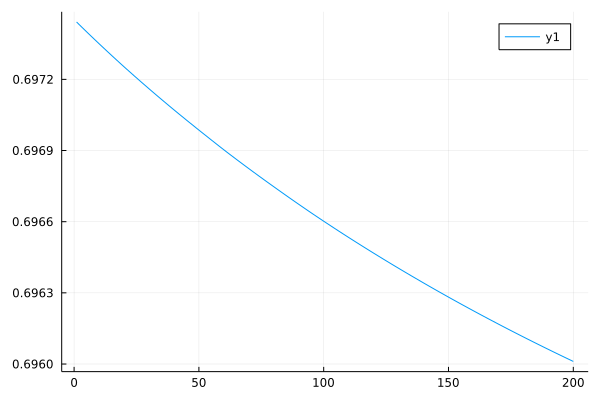

In [22]:
plot(1:epochs, train_loss)

## CIFAR10

In [23]:
using Statistics
using Flux, Flux.Optimise
using Metalhead, Images
using Metalhead: trainimgs
using Images.ImageCore
using Flux: onehotbatch, onecold
using Base.Iterators: partition
using CUDA

In [24]:
Metalhead.download(CIFAR10)

In [25]:
X = trainimgs(CIFAR10);

In [26]:
X[1].ground_truth.class

7

In [27]:
labels = onehotbatch([X[i].ground_truth.class for i in 1:50000], 1:10)

10×50000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  1  1
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅     ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  1     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅

,,,,,,,,,

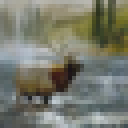
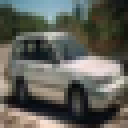
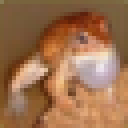
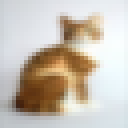
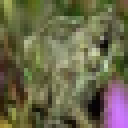
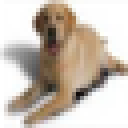
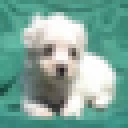
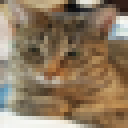
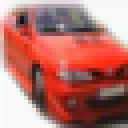
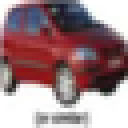

In [28]:
using StatsBase

image(x) = x.img
ground_truth(x) = x.ground_truth
image.(X[sample(1:end, 10)])

In [29]:
getarray(X) = float.(permutedims(channelview(X), (2, 3, 1)))
imgs = [getarray(X[i].img) for i in 1:50000];

In [30]:
train = ([(cat(imgs[i]..., dims=4), labels[:,i]) for i in partition(1:49000, 1000)]) |> gpu
valset = 49001:50000
valX = cat(imgs[valset]..., dims=4) |> gpu
valY = labels[:, valset] |> gpu

10×1000 OneHotMatrix(::CuArray{UInt32, 1, CUDA.Mem.DeviceBuffer}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  1  1
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅

In [31]:
m = Chain(
  Conv((5,5), 3=>16, relu),
  MaxPool((2,2)),
  Conv((5,5), 16=>8, relu),
  MaxPool((2,2)),
  x -> reshape(x, :, size(x, 4)),
  Dense(200, 120),
  Dense(120, 84),
  Dense(84, 10),
  softmax) |> gpu

Chain(
  Conv((5, 5), 3 => 16, relu),          # 1_216 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 16 => 8, relu),          # 3_208 parameters
  MaxPool((2, 2)),
  var"#13#14"(),
  Dense(200, 120),                      # 24_120 parameters
  Dense(120, 84),                       # 10_164 parameters
  Dense(84, 10),                        # 850 parameters
  NNlib.softmax,
)                   # Total: 10 arrays, 39_558 parameters, 1.773 KiB.

In [32]:
using Flux: Momentum

loss(x, y) = sum(Flux.crossentropy(m(x), y))
opt = Momentum(0.01)

Momentum(0.01, 0.9, IdDict{Any, Any}())

In [33]:
accuracy(x, y) = mean(onecold(m(x), 1:10) .== onecold(y, 1:10))

accuracy (generic function with 1 method)

In [40]:
epochs = 100

for epoch = 1:epochs
    for d in train
        gs = gradient(params(m)) do
            l = loss(d...)
        end
        update!(opt, params(m), gs)
    end
    @show accuracy(valX, valY)
end

accuracy(valX, valY) = 0.568
accuracy(valX, valY) = 0.561
accuracy(valX, valY) = 0.577
accuracy(valX, valY) = 0.592
accuracy(valX, valY) = 0.58
accuracy(valX, valY) = 0.593
accuracy(valX, valY) = 0.593
accuracy(valX, valY) = 0.581
accuracy(valX, valY) = 0.577
accuracy(valX, valY) = 0.577
accuracy(valX, valY) = 0.582
accuracy(valX, valY) = 0.583
accuracy(valX, valY) = 0.579
accuracy(valX, valY) = 0.582
accuracy(valX, valY) = 0.604
accuracy(valX, valY) = 0.588
accuracy(valX, valY) = 0.58
accuracy(valX, valY) = 0.588
accuracy(valX, valY) = 0.593
accuracy(valX, valY) = 0.587
accuracy(valX, valY) = 0.583
accuracy(valX, valY) = 0.592
accuracy(valX, valY) = 0.6
accuracy(valX, valY) = 0.594
accuracy(valX, valY) = 0.605
accuracy(valX, valY) = 0.586
accuracy(valX, valY) = 0.599
accuracy(valX, valY) = 0.605
accuracy(valX, valY) = 0.6
accuracy(valX, valY) = 0.603
accuracy(valX, valY) = 0.608
accuracy(valX, valY) = 0.597
accuracy(valX, valY) = 0.595
accuracy(valX, valY) = 0.593
accuracy(valX, valY)

In [35]:
valset = valimgs(CIFAR10)
valimg = [getarray(valset[i].img) for i in 1:10000]
labels = onehotbatch([valset[i].ground_truth.class for i in 1:10000],1:10)
test = gpu.([(cat(valimg[i]..., dims = 4), labels[:,i]) for i in partition(1:10000, 1000)]);

,,,,,,,,,

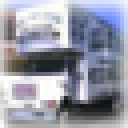
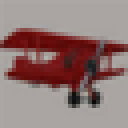
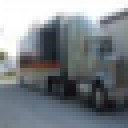
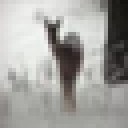
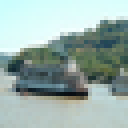
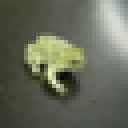
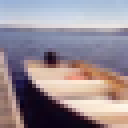
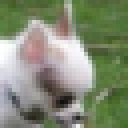
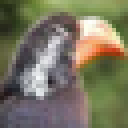
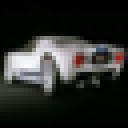

In [41]:
ids = rand(1:10000, 10)
image.(valset[ids])

In [42]:
rand_test = getarray.(image.(valset[ids]))
rand_test = cat(rand_test..., dims = 4) |> gpu
rand_truth = ground_truth.(valset[ids])
m(rand_test)

10×10 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.107397     0.500621    0.082807     …  0.00038321   0.0158291
 0.0543001    0.253871    0.00666705      0.000397608  0.772317
 0.000217852  0.0122288   0.00269124      0.0513079    0.000239244
 0.000234222  0.00255588  0.00537099      0.0529085    0.000235109
 0.0204572    0.0500711   0.00528769      0.00321326   0.000120221
 0.000137664  0.0024113   0.0038629    …  0.611229     0.000111228
 2.18318f-5   0.00979558  0.000470431     0.0169232    0.00180357
 0.0076268    0.0796559   0.00287014      0.26164      0.000956218
 0.0592888    0.00483304  0.0430996       9.06769f-6   0.0264528
 0.750318     0.0839559   0.846873        0.00198797   0.181936

In [43]:
accuracy(test[1]...)

0.623

In [44]:
class_correct = zeros(10)
class_total = zeros(10)
for i in 1:10
  preds = m(test[i][1])
  lab = test[i][2]
  for j = 1:1000
    pred_class = findmax(preds[:, j])[2]
    actual_class = findmax(lab[:, j])[2]
    if pred_class == actual_class
      class_correct[pred_class] += 1
    end
    class_total[actual_class] += 1
  end
end

class_correct ./ class_total

10-element Vector{Float64}:
 0.664
 0.748
 0.538
 0.344
 0.608
 0.549
 0.722
 0.684
 0.769
 0.699

In [45]:
using BSON: @save

In [46]:
@save "mymodel.bson" m